# ANN with 5 strain rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("mime")
import h5py
from scipy.optimize import curve_fit
import lmfit
import os

colors = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777', '#440000', '#004400', "#000044", '#444400', '#440044', "#0044444", '#444444','#000000']

In [2]:
baseSize = (8, 6)  # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <= 12): return 4, 3
    return 0, 0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0] * y, baseSize[1] * x

In [3]:
h5f = h5py.File('../GleebleData.h5','r')
allData = h5f['all'][:]
shortData = h5f['short'][:]
h5f.close()

In [4]:
allData.shape, shortData.shape

((21030, 4), (1080, 4))

Remove first point of each curve, where $\varepsilon^p=0$

In [5]:
identData = allData[allData[:,0] != 0]
identData0 = np.copy(identData)

Remove data to reconstruct

In [6]:
missed = 5
identData = identData[identData[:,1] != missed]
identData0 = np.copy(identData)
identData.shape

(17500, 4)

# Identification of the ANN parameters


In [7]:
# Importation de TensorFlow
import tensorflow as tf
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers.core import Dense, Activation
from keras import optimizers
tf.keras.backend.set_floatx('float64')

In [8]:
training = False

In [9]:
epspl = np.unique(identData[:,0])
depspl = np.unique(allData[:,1])
Tl = np.unique(identData[:,2])
nEpsp = depspl.shape[0]

T0 = Tl[0]
epsLogBase = depspl[0]
Tm = 1460

In [10]:
identData[:,1] = np.log(identData[:,1] / epsLogBase)

In [11]:
minEntries = identData.min(axis=0)
maxEntries = identData.max(axis=0)
rangeEntries = maxEntries - minEntries
NNentries = (identData - minEntries) / rangeEntries

In [12]:
print("Max error for normalized data is : %5.4E" %(NNentries * rangeEntries + minEntries - identData).max())

Max error for normalized data is : 1.4211E-14


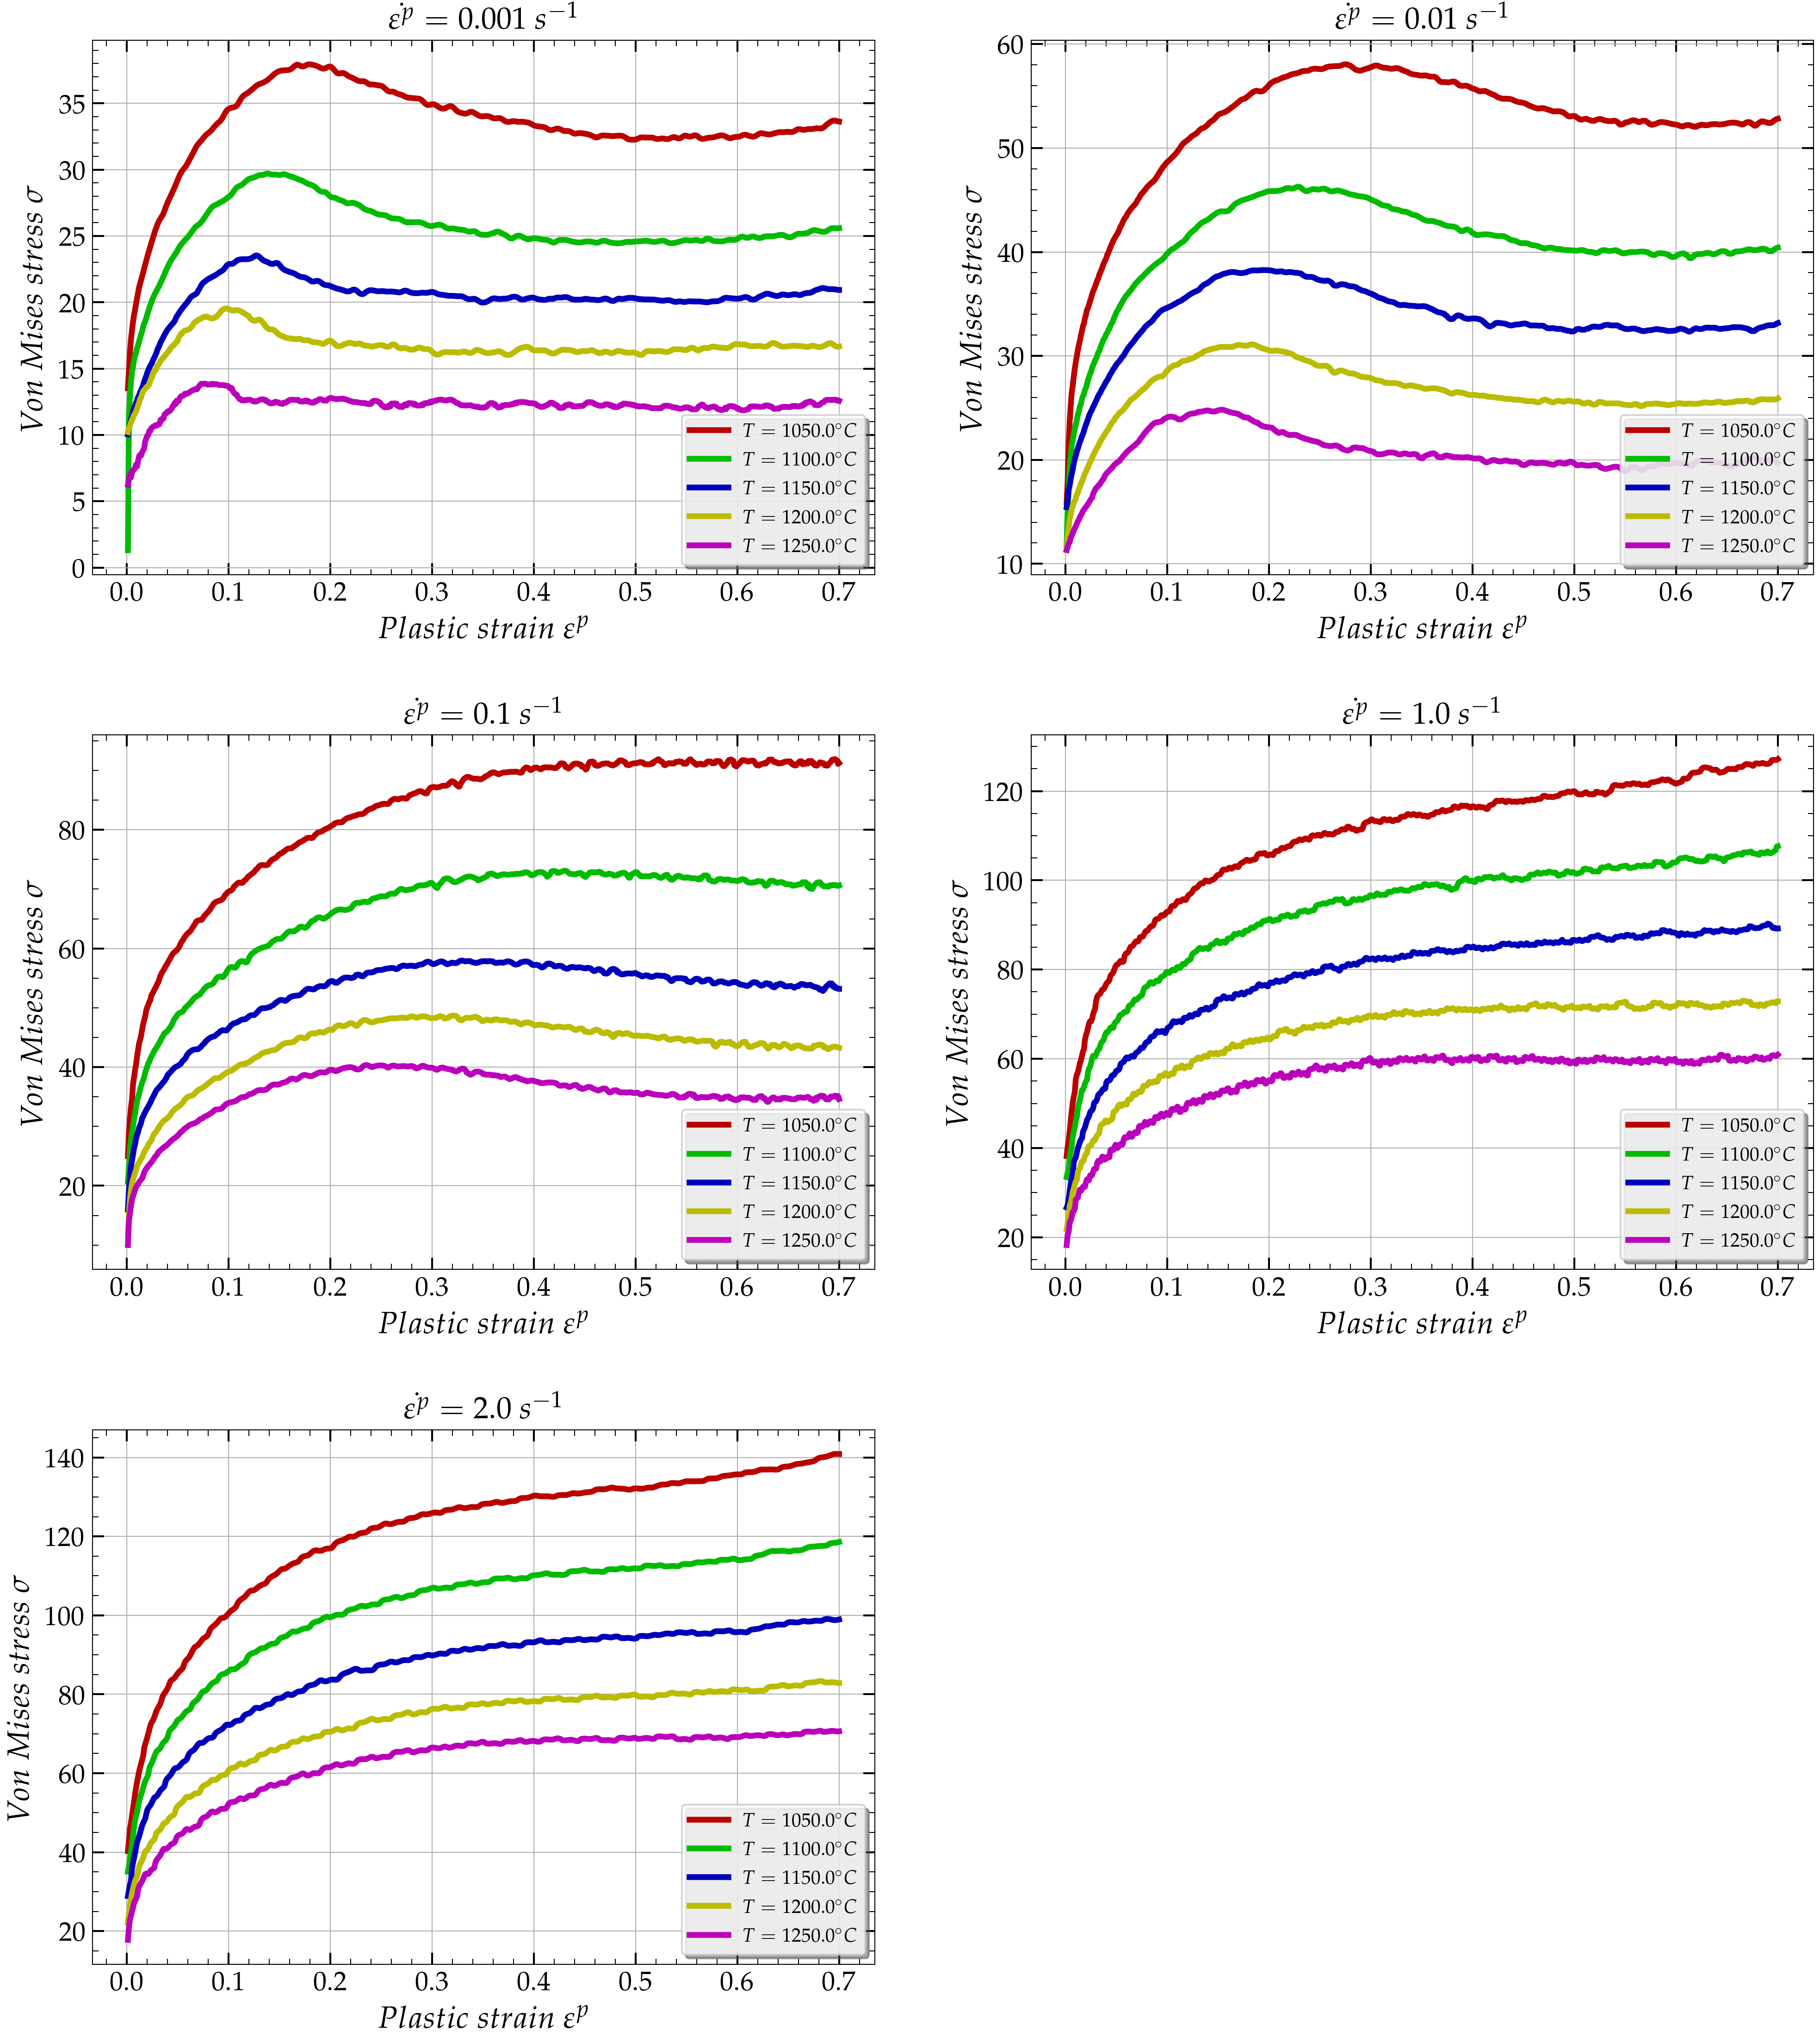

In [13]:
plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
plt.subplots_adjust(hspace = 0.3)
idx = 1
for epspv, epspvv in zip(np.unique(identData[:,1]), depspl):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    cl = 0
    for T, TOrig in zip(np.unique(identData[:,2]), Tl):
        # filter on T
        data = NNentries[(identData[:,2]==T) & (identData[:,1]==epspv), :]
        # Plot the curves
        plt.plot(data[:,0]*rangeEntries[0]+minEntries[0], data[:,3]*rangeEntries[3]+minEntries[3], label=r'$T=' + str(TOrig) + '^{\circ}C$', linewidth = 3)
        cl += 1
    plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 10)
    plt.xlabel(r'$Plastic\ strain\ \varepsilon^{p}$', fontsize = 16)
    plt.ylabel(r'$Von\ Mises\ stress\ \sigma$', fontsize = 16)
    plt.title(r'$\dot{\varepsilon^p}=' + str(epspvv) + '\ s^{-1}$', fontsize = 16)
    idx += 1
#plt.show()

In [14]:
colEps = 0
colEpsp = 1
colT = 2
colSig = 3
NNinput = NNentries[:,colEps:colSig]
NNoutput = NNentries[:,colSig]
NNinput.shape, NNoutput.shape

((17500, 3), (17500,))

In [15]:
if training:
    models = []  # The list of models to use
    convergenceDatas = []   # To store convergence curves
    
    # FACT = ['tanh', 'sigmoid']
    # COUCH = [5, 7, 9, [5,3], [7,4], [9,5]]
    
    FACT = ['sigmoid']
    COUCH = [[7, 5],[9, 5],[9, 7],[13, 7],[15, 7]]
    COUCH = [[15,7]]
    
    for f in FACT:
        for c in COUCH:
            desc = '3'
            model = Sequential()
            if type(c) == list:
                fst = True
                for k in c:
                    if (fst): model.add(Dense(k, input_dim = 3, activation = f))
                    else: model.add(Dense(k, activation = f))
                    fst = False
                    desc += '-' + str(k)
            else:
                model.add(Dense(c, input_dim = 3, activation = f))
                desc += '-' + str(c)
            model.add(Dense(1))
            desc += '-1-' + f
            model._name = desc
            models.append(model)
            convergenceDatas.append([desc, np.array([])])

In [16]:
if training:
    for model in models:
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()

In [17]:
def saveInternalMatrices(ANN, filename):
    if len(ANN.layers) == 1: 
        np.savez(filename,
                 logBase = np.array([epsLogBase]),
                 minEntries = minEntries, 
                 maxEntries = maxEntries,
                 w1 = ANN.layers[0].get_weights()[0].T, 
                 b1 = ANN.layers[0].get_weights()[1].reshape(len(ANN.layers[0].get_weights()[1]),1))
    if len(ANN.layers) == 2: 
        np.savez(filename, 
                 logBase = np.array([epsLogBase]),
                 minEntries = minEntries, 
                 maxEntries = maxEntries,
                 w1 = ANN.layers[0].get_weights()[0].T, 
                 b1 = ANN.layers[0].get_weights()[1].reshape(len(ANN.layers[0].get_weights()[1]),1),
                 w2 = ANN.layers[1].get_weights()[0].T, 
                 b2 = ANN.layers[1].get_weights()[1].reshape(len(ANN.layers[1].get_weights()[1]),1))
    if len(ANN.layers) == 3: 
        np.savez(filename, 
                 logBase = np.array([epsLogBase]),
                 minEntries = minEntries, 
                 maxEntries = maxEntries,
                 w1 = ANN.layers[0].get_weights()[0].T, 
                 b1 = ANN.layers[0].get_weights()[1].reshape(len(ANN.layers[0].get_weights()[1]),1),
                 w2 = ANN.layers[1].get_weights()[0].T, 
                 b2 = ANN.layers[1].get_weights()[1].reshape(len(ANN.layers[1].get_weights()[1]),1),
                 w3 = ANN.layers[2].get_weights()[0].T, 
                 b3 = ANN.layers[2].get_weights()[1].reshape(len(ANN.layers[2].get_weights()[1]),1)) 
    if len(ANN.layers) == 4: 
        np.savez(filename, 
                 logBase = np.array([epsLogBase]),
                 minEntries = minEntries, 
                 maxEntries = maxEntries,
                 w1 = ANN.layers[0].get_weights()[0].T, 
                 b1 = ANN.layers[0].get_weights()[1].reshape(len(ANN.layers[0].get_weights()[1]),1),
                 w2 = ANN.layers[1].get_weights()[0].T, 
                 b2 = ANN.layers[1].get_weights()[1].reshape(len(ANN.layers[1].get_weights()[1]),1),
                 w3 = ANN.layers[2].get_weights()[0].T, 
                 b3 = ANN.layers[2].get_weights()[1].reshape(len(ANN.layers[2].get_weights()[1]),1),
                 w4 = ANN.layers[3].get_weights()[0].T, 
                 b4 = ANN.layers[3].get_weights()[1].reshape(len(ANN.layers[3].get_weights()[1]),1))     

In [18]:
dataPath = 'ANN-5e'

iterationsNumber = 60 # Define the number of iteration to do
epochNumber = 100     # Define the number of epoch for each iteration
subSave = True

if training:
    for model, convergenceData in zip (models, convergenceDatas):
        print("MODEL :", model.name)
        if (subSave):
            try:
                os.mkdir(dataPath + '/' + model.name)
            except:
                pass
        for i in range(iterationsNumber):
            history = model.fit(NNinput, NNoutput, epochs = epochNumber, verbose = 0, shuffle = True)
            loss = history.history['loss']
            convergenceData[1] = np.append(convergenceData[1], loss)
            if (subSave):
                saveInternalMatrices(model, dataPath + '/' + model.name + '/ANN-' + str(i))
            saveInternalMatrices(model, dataPath + '/' + model.name + '.npz')
    
            print("Iteration :", i + 1, "/", iterationsNumber, '-> %8.6E' % loss[-1], "  ", end = '\r')
        print("\n")

In [19]:
if training:
    for model in models:
        model.save(dataPath + '/' + model.name + '/model')

In [20]:
loadModels = ['3-15-7-1-sigmoid', '3-13-7-1-sigmoid', '3-7-5-1-sigmoid', '3-9-5-1-sigmoid','3-9-7-1-sigmoid']
loadModels = ['3-15-7-1-sigmoid']

In [21]:
if (training==False):
    models = []              # The list of models to use
    for modName in loadModels:
        new_model = tf.keras.models.load_model(dataPath + '/' + modName + '/model')
        models.append(new_model)

2022-11-16 13:52:56.740597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
if training:
    for convergenceData in convergenceDatas:
        name = convergenceData[0]
        convCurve = convergenceData[1]
        np.savez(dataPath + '/CD-' + name, convCurve = convCurve)
        print("Convergence data %s saved" % (name))

In [23]:
if (training==False):
    convergenceDatas = []   # To store convergence curves
    for name in loadModels:
        NN = np.load(dataPath + '/CD-' + name + '.npz')
        cc = [name, NN['convCurve']]
        convergenceDatas.append(cc)

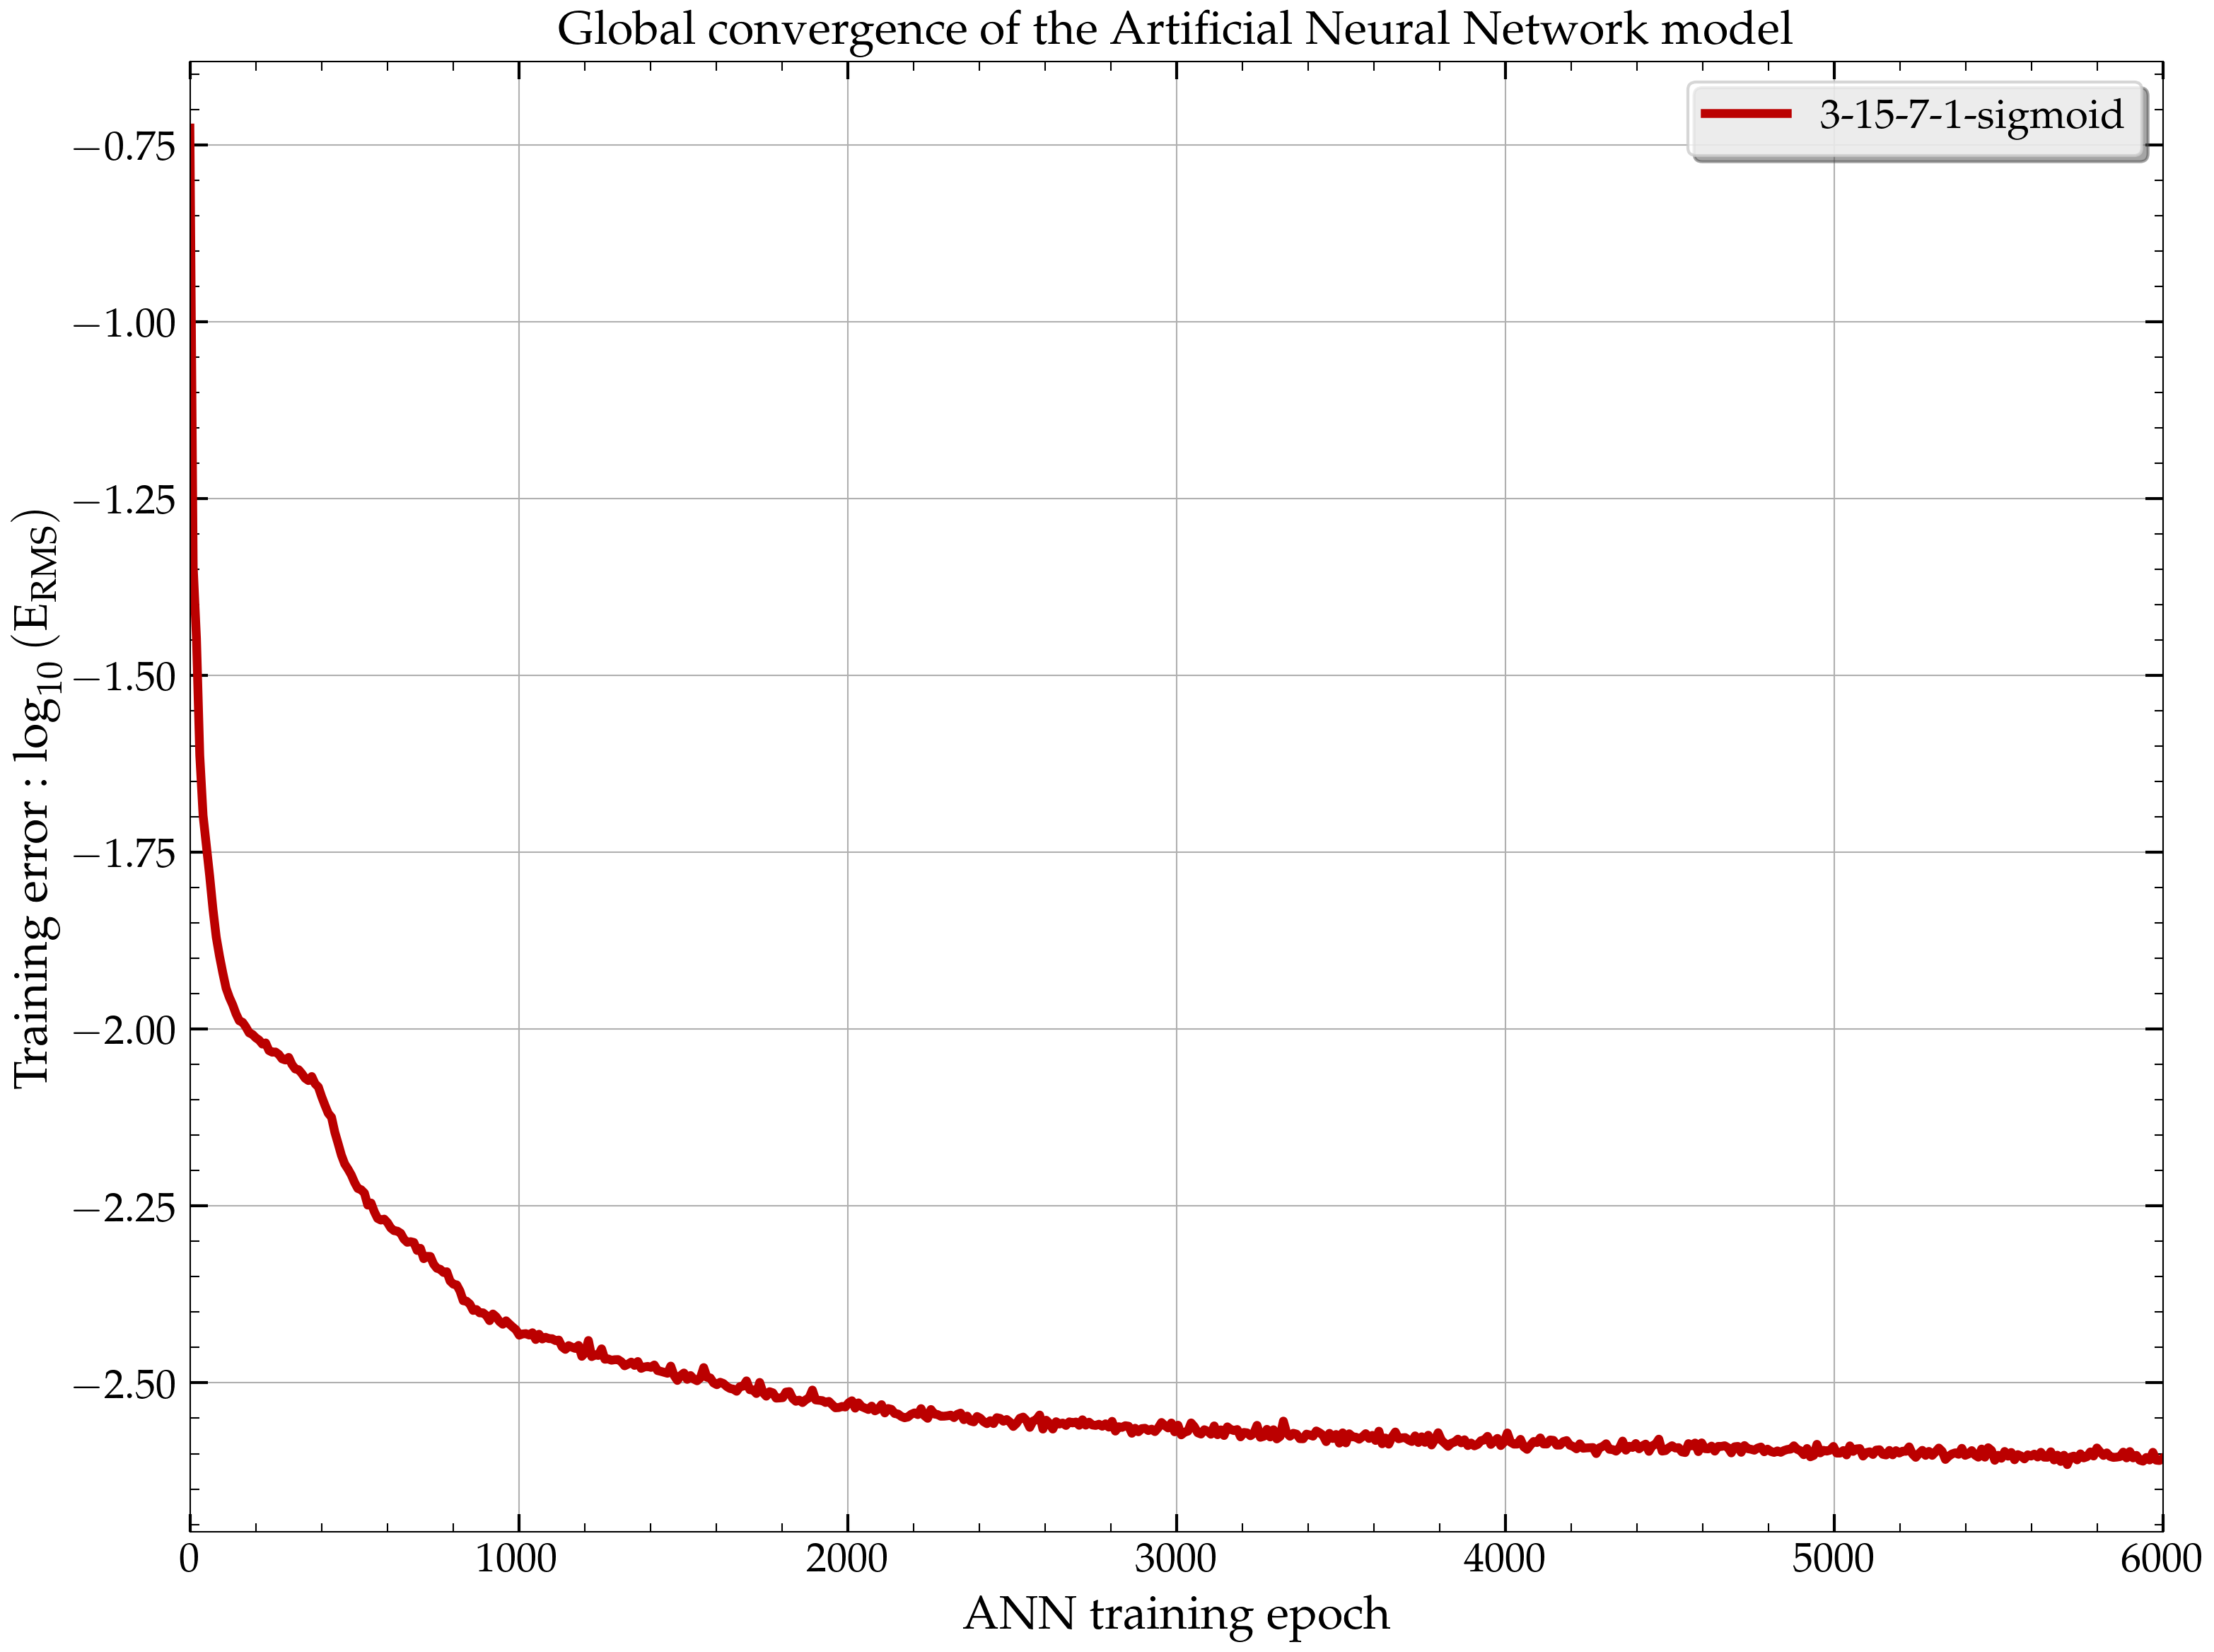

In [24]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
cl = 0
for convergenceData in convergenceDatas:
    name = convergenceData[0]
    curve = convergenceData[1]
    shortCurve = curve[::10]
    x = np.linspace(0, len(curve), len(shortCurve))
    plt.plot(x, np.log10(np.sqrt(shortCurve)), label = name, color=colors[cl], linewidth = 3)
    cl += 1
#plt.grid()
plt.xlabel(r'ANN training epoch', fontsize = 16)
#plt.ylim(-5.25, -3.5)
plt.xlim(x.min(), x.max())

plt.ylabel(r'Training error : $\log_{10}\left(\text{E}_\text{RMS}\right)$', fontsize = 16)
plt.title(r'Global convergence of the Artificial Neural Network model', fontsize = 16)
plt.legend(loc = 'upper right',fancybox = True, numpoints = 1, fontsize = 14)
plt.savefig("Conv-ANN-5e.svg")
#plt.show()

In [25]:
model = models[0]
model.summary()

Model: "3-15-7-1-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                60        
                                                                 
 dense_1 (Dense)             (None, 7)                 112       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


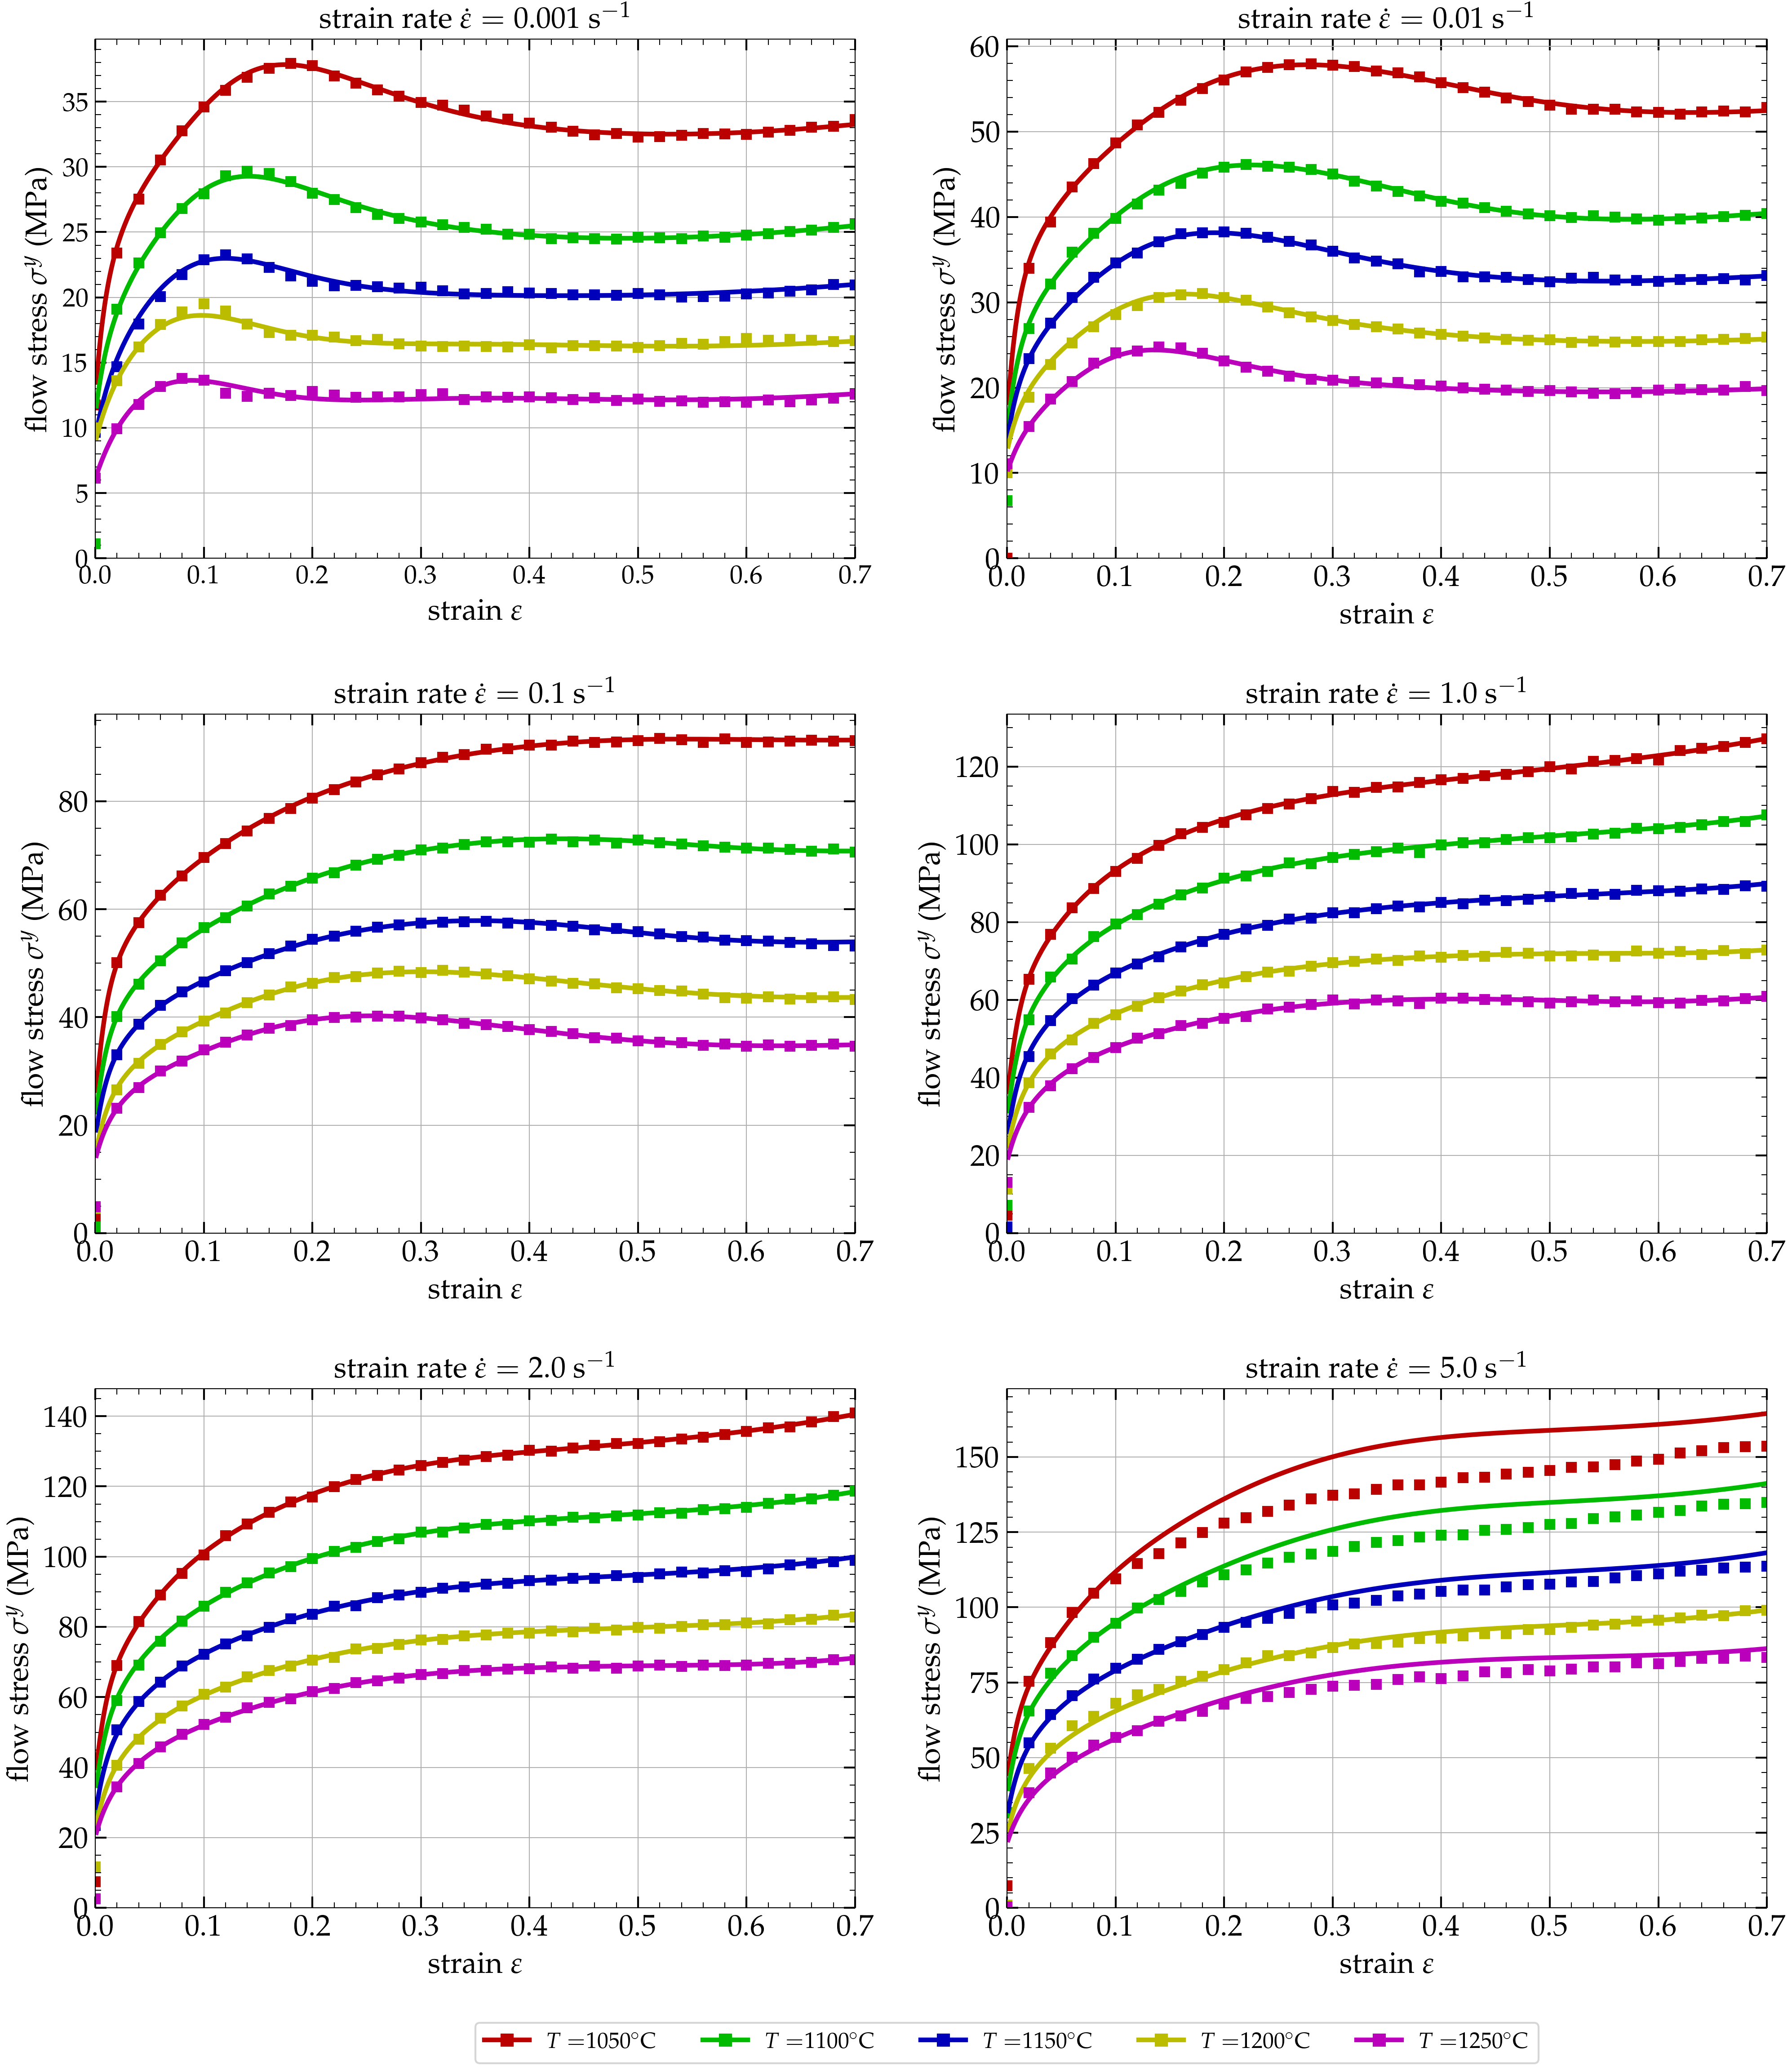

In [26]:
# Plot the curves
from matplotlib.lines import Line2D
def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)

for model in models:
    plt.figure(figsize = sbPlotSize(nEpsp))
    plt.rc('text', usetex = True)
    idx = 1
    plt.subplots_adjust(hspace = 0.3)
    for epsp in list(depspl):
        xs, ys = sbPlot(nEpsp)
        plt.subplot(xs, ys, idx)
        sbdata = shortData[shortData[:,1]==epsp]
        cl =0
        for temp in list(Tl):
            sbdata1 = sbdata[sbdata[:,2]==temp]
            plt.plot(sbdata1[:,0], sbdata1[:,3], colors[cl], marker = 's', markersize = 5, linestyle = 'none')
            inp = np.zeros((epspl.shape[0],3))
            inp[:,0] = (epspl - minEntries[0]) / rangeEntries[0]
            inp[:,1] = (np.log(epsp / epsLogBase) - minEntries[1]) / rangeEntries[1]
            inp[:,2]  = (temp - minEntries[2]) / rangeEntries[2]
            plt.plot(epspl, model.predict(inp)*rangeEntries[3]+minEntries[3], colors[cl], linewidth = 2.5)
            plt.rcParams['xtick.labelsize'] = 16
            plt.rcParams['ytick.labelsize'] = 16
            cl +=1
        plt.xlim(0, 0.7)
        plt.ylim(bottom=0)
        plt.xlabel(r'strain $\varepsilon$', fontsize = 16) # Labels the x axis
        plt.ylabel(r'flow stress $\sigma^y$ (MPa)', fontsize = 16) # Labels the y axis
        plt.title(r'strain rate $\dot{\varepsilon} = ' + str(epsp) + '$ s$^{-1}$', fontsize = 16) # Self explicit command
        idx += 1
        
    legendLines = []
    cl = 0
    for temp in list(Tl):
        legendLines.append((r'$T=$' + str(int(temp)) + r'$^{\circ}$C', {'color':colors[cl], 'linestyle':'-', 'linewidth':2.5, 'marker':'s'}))
        cl += 1
    
    plt.legend([create_dummy_line(**l[1]) for l in legendLines],[l[0] for l in legendLines], 
               loc = 'upper center', fontsize = 12, ncols = 5, bbox_to_anchor = (0.0, -0.2), shadow = False)
    
    plt.savefig("CompExpANN-5e-"+model.name+".svg")
    #plt.show()

In [27]:
for model in models:
    ARstress = (model.predict(NNinput)*rangeEntries[3]+minEntries[3]).flatten()
    EAAR = np.sum(np.abs((identData0[:,3] - ARstress)/(identData0[:,3])))*100/ARstress.shape[0]
    RMSE = np.sqrt(np.sum((identData0[:,3] - ARstress)**2)/ARstress.shape[0])
    print("Model %s" %(model.name))
    print('  RMSE = %.2f' %(RMSE)+' MPa')
    print("  EAAR = %.2f" %(EAAR) + ' %')

Model 3-15-7-1-sigmoid
  RMSE = 0.32 MPa
  EAAR = 0.61 %


In [28]:
saveData = allData[allData[:,0] != 0]
saveData[:,1] = np.log(saveData[:,1] / epsLogBase)
saveNNentries = ((saveData - minEntries) / rangeEntries)[:,0:3]
saveNNentries.shape, allData[allData[:,0] != 0].shape

((21000, 3), (21000, 4))

In [29]:
for model in models:
    ARstress = (model.predict(saveNNentries)*rangeEntries[3]+minEntries[3])
    data = np.concatenate((allData[allData[:,0] != 0][:,0:3],ARstress),axis=1)
    h5f = h5py.File(dataPath+'/'+model.name+'.h5','w')
    h5f.create_dataset('data', data = data)
    h5f.close()

In [30]:
def np2lat(f, n, A, prec=4):
    if (A.ndim == 1):
        cols = 1
    else:
        cols = A.shape[1]
    tabformat = '%.'+str(prec)+'f'
    tabalign = 'r'*cols
    f.write('\\begin{equation*}\n')
    f.write(n+' = ')
    f.write('\\left[\n')
    f.write('\\begin{array}{%s}\n' %tabalign)
    np.savetxt(f, A, fmt=tabformat, delimiter=' & ', newline='\\\\ \n')
    f.write('\\end{array}\\right]\n')
    f.write('\\end{equation*}\n')

def writeLatex(filename, model, prec=4):
    f = open(filename, 'w')
    w1, b1 = model.layers[0].get_weights()
    w2, b2 = model.layers[1].get_weights()
    w3, b3 = model.layers[2].get_weights()
    np2lat(f, '\\w_1',w1.T, prec)
    np2lat(f,'\\overrightarrow{b}_1',b1, prec)
    np2lat(f, '\\w_2^T',w2, prec)
    np2lat(f,'\\overrightarrow{b}_2',b2, prec)
    np2lat(f, '\\overrightarrow{w}_3',w3, prec)
    np2lat(f,'b_3',b3, prec)
    np2lat(f, 'logBase',np.array([epsLogBase]), prec)
    np2lat(f, 'minEntries',minEntries, prec)
    np2lat(f, 'maxEntries',maxEntries, prec)
    f.close()

In [31]:
for model in models:
    writeLatex(model.name+'-5e.tex',model,prec=4)